In [15]:
import pandas as pd
import numpy as np
import mlflow
from mlflow import MlflowClient
from mlflow.tracking import MlflowClient
from functools import partial

- Objectifs :
    - minimiser les faux négatifs (métrique = recall le plus élevé possible)
    - minimiser les faux positifs (métrique = precision le plus élevé possible)
- Déséquilibres dans le jeu de données : trop de bons clients (0) par rapport aux mauvais clients (1) --> utiliser l'argument class_weight pour résoudre le pb ds la mise en place des modèles

Serveur à héberger sur serveur Databricks, pas local

In [2]:
# Création de l'expérience MLFlow

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")
mlflow.set_tracking_uri("http://127.0.0.1:8080")
all_experiments = client.search_experiments()
print(all_experiments)

# Provide an Experiment description that will appear in the UI
#experiment_description = ("Classification des clients projet 7")

# Tag de l'expérience
#experiment_tags = {
#    "project_name": "Projet_7",
#    "mlflow.note.content": experiment_description,
#}

# Create the Experiment, providing a unique name
#projet_7_experiment = client.create_experiment(
#    name="Projet_7", tags=experiment_tags
#)

# Sets the current active experiment to the "Apple_Models" experiment and
# returns the Experiment metadata
projet_7_experiment_current = mlflow.set_experiment("Projet_7")
mlflow.set_experiment("Projet_7")
# Define an artifact path that the model will be saved to.
artifact_path = "Projet_7"


[<Experiment: artifact_location='mlflow-artifacts:/445817929057729288', creation_time=1720791165501, experiment_id='445817929057729288', last_update_time=1720791165501, lifecycle_stage='active', name='Projet_7', tags={'mlflow.note.content': 'Classification des clients projet 7',
 'project_name': 'Projet_7'}>, <Experiment: artifact_location='mlflow-artifacts:/181467598177086032', creation_time=1720684342295, experiment_id='181467598177086032', last_update_time=1720684342295, lifecycle_stage='active', name='Apple_Models', tags={'mlflow.note.content': 'This is the grocery forecasting project. This '
                        'experiment contains the produce models for apples.',
 'project_name': 'grocery-forecasting',
 'project_quarter': 'Q3-2023',
 'store_dept': 'produce',
 'team': 'stores-ml'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1720645090927, experiment_id='0', last_update_time=1720645090927, lifecycle_stage='active', name='Default', tags={}>]


## Préparation des données

In [3]:
# Importation de la data

application_train_preprocessed = pd.read_csv("../data/application_train_preprocessed.csv")

In [4]:
# Split train/test
from sklearn.model_selection import train_test_split

X = application_train_preprocessed.drop('TARGET', axis=1)
y = application_train_preprocessed['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

 # Extraction du nom des variables
features = list(X.columns)

# Imputation valeurs manquantes par la médiane
imputer = SimpleImputer(strategy = 'median')
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Normalisation avec MinMaxScaler, plus adapté que Standard Scaler
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (215257, 241)
Testing data shape:  (92254, 241)


## Mise en place des fonctions modèle et résultats

Remettre importations au début avec les versions

In [56]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score

f1_beta_scorer = make_scorer(fbeta_score, beta=10)

# Modèle
def entrainementModeleAvecCV(modele, arguments_modele, param_grid):
    modele = modele(**arguments_modele) # argument class_weight pour gérer déséquilibre des données

    """CROSS VALIDATION"""
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=modele,
                               param_grid=param_grid,
                               scoring=f1_beta_scorer,
                               cv=cv,
                               verbose=0,
                               n_jobs=8)

    # Entraînement de la cross validation
    grid_search.fit(X_train, y_train)

    print("Meilleurs paramètres trouvés :", grid_search.best_params_)
    print("Meilleur score F1-bêta :", grid_search.best_score_)

    meilleurModele = grid_search.best_estimator_
    
    """PREDICTIONS"""
    model_pred_proba = meilleurModele.predict_proba(X_test)[:, 1]
    model_pred = meilleurModele.predict(X_test)

    return {
        "modele":modele,
        "hyperparametres": meilleurModele,
        "model_pred_proba": model_pred_proba,
        "model_pred": model_pred
    }
    
# Entrainement sur le jeu de train
#log_reg.fit(X_train, y_train)

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, fbeta_score, precision_recall_curve
import shap

def affichageResultatsModele(model_dict):

    model_pred = model_dict["model_pred"]
    model_pred_proba = model_dict["model_pred_proba"]
    hyperparametres = model_dict["hyperparametres"]
    hyperparametres_dict = model_dict["hyperparametres"].get_params()
    
    """MATRICE DE CONFUSION"""
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Création de la matrice de confusion avec les labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bons clients', 'Mauvais clients'])
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False, values_format='')
        
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')
    plt.title('Matrice de Confusion')
    plt.show()

    """METRIQUES"""
    precision = round(precision_score(y_test, model_pred), 4)
    recall = round(recall_score(y_test, model_pred), 4)
    f1 = round(f1_score(y_test, model_pred), 4)
    roc_auc = round(roc_auc_score(y_test, model_pred_proba), 4)
    f1_beta = round(fbeta_score(y_test, model_pred, beta = 10), 4)
    
    metrics = {"precision":precision, "recall":recall, "f1":f1, "f1_beta":f1_beta, "roc_auc":roc_auc}
    display(metrics)

    """FEATURE IMPORTANCE GLOBALE"""
    #explainer = shap.Explainer(hyperparametres, X_train)
    #shap_values = explainer(X_test)
    #shap.summary_plot(shap_values, X_test)

    """ENVOI DANS LE MLFLOW"""
    with mlflow.start_run() as run:
        mlflow.set_tag("model_name", type(hyperparametres).__name__) #nom du modèle
        mlflow.log_params(hyperparametres_dict) #hyperparametres du modèle
        mlflow.log_metrics(metrics) #metriques du modele    
        mlflow.sklearn.log_model(sk_model=hyperparametres, artifact_path="Projet_7")

Chiffres après la virgule

In [8]:
# Importance locale des caractéristiques pour un échantillon

def featureImportanceLocale(model_dict, individu):
    hyperparametres = model_dict["hyperparametres"]
    shap.initjs()
    explainer = shap.Explainer(hyperparametres, X_train)
    shap_values = explainer(X_test)
    shap.force_plot(shap_values[0].base_values, shap_values[0].values, X_test.iloc[0], feature_names=features)

## Test de différents modèles

#### LogisticRegression

Meilleurs paramètres trouvés : {'C': 1, 'max_iter': 300}
Meilleur score F1-bêta : 0.4111151720737475


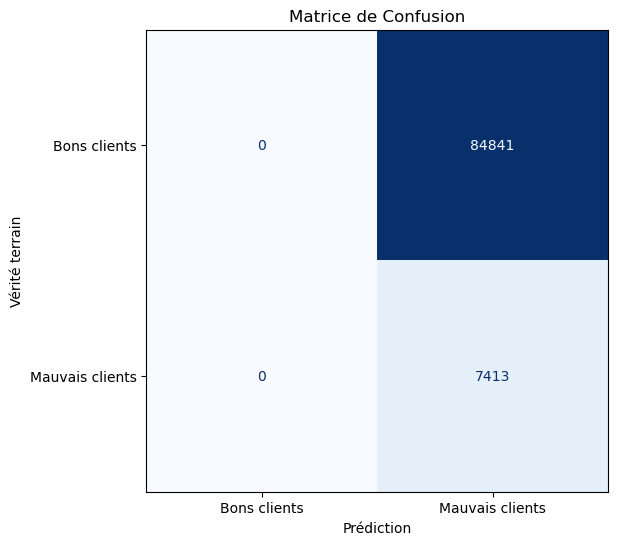

{'precision': 0.1593,
 'recall': 0.6758,
 'f1': 0.2578,
 'f1_beta': 0.4099,
 'roc_auc': 0.747}

In [38]:
from sklearn.linear_model import LogisticRegression

arguments_modele={"class_weight":"balanced"}

param_grid = {
    "C": [0.1, 1, 10],
    "max_iter": [100, 200, 300]
}

LogisticRegression_entraine = entrainementModeleAvecCV(LogisticRegression, arguments_modele, param_grid, 2)
affichageResultatsModele(LogisticRegression_entraine)
#featureImportanceLocale(LogisticRegression_entraine, 0)

#### LightGBM Classifier

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11949
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 233
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

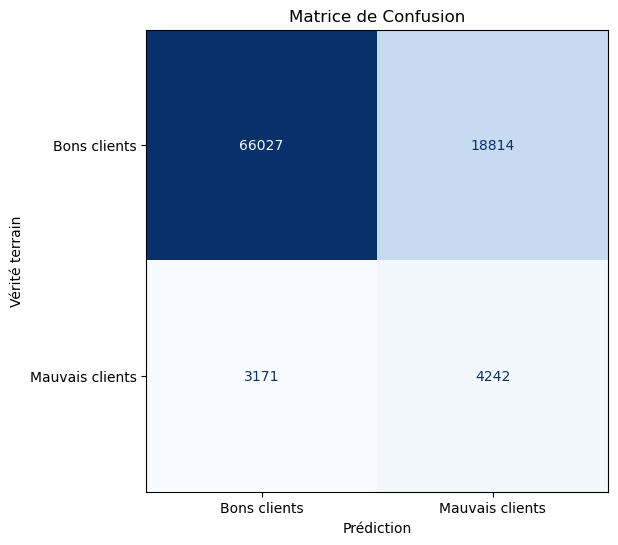

{'precision': 0.184,
 'recall': 0.5722,
 'f1': 0.2784,
 'f1_beta': 0.4024,
 'roc_auc': 0.7469}

In [10]:
import lightgbm as lgb

arguments_modele={"class_weight":"balanced"}

param_grid = {
    "num_leaves":[31, 63, 127],
    "n_estimators":[100,200,300],
    "max_depth":[3,5,7]
}

LGBMClassifier_entraine = entrainementModeleAvecCV(lgb.LGBMClassifier, arguments_modele, param_grid, 0.5)
affichageResultatsModele(LGBMClassifier_entraine)
#featureImportanceLocale(LGBMClassifier_entraine, 0)

Essayer le check_additivity=False voir si ça passe

#### Catboost Classifier

0:	learn: 0.6874299	total: 26.1ms	remaining: 7.81s
1:	learn: 0.6824965	total: 50ms	remaining: 7.45s
2:	learn: 0.6778252	total: 74ms	remaining: 7.33s
3:	learn: 0.6736413	total: 96.5ms	remaining: 7.14s
4:	learn: 0.6699207	total: 121ms	remaining: 7.13s
5:	learn: 0.6664990	total: 172ms	remaining: 8.42s
6:	learn: 0.6632400	total: 194ms	remaining: 8.14s
7:	learn: 0.6602153	total: 219ms	remaining: 8s
8:	learn: 0.6574736	total: 244ms	remaining: 7.9s
9:	learn: 0.6548603	total: 268ms	remaining: 7.78s
10:	learn: 0.6524521	total: 294ms	remaining: 7.72s
11:	learn: 0.6502789	total: 319ms	remaining: 7.65s
12:	learn: 0.6481455	total: 346ms	remaining: 7.64s
13:	learn: 0.6461035	total: 368ms	remaining: 7.52s
14:	learn: 0.6442092	total: 393ms	remaining: 7.46s
15:	learn: 0.6424619	total: 417ms	remaining: 7.41s
16:	learn: 0.6407325	total: 443ms	remaining: 7.38s
17:	learn: 0.6391274	total: 467ms	remaining: 7.32s
18:	learn: 0.6377098	total: 492ms	remaining: 7.28s
19:	learn: 0.6363126	total: 514ms	remaining: 

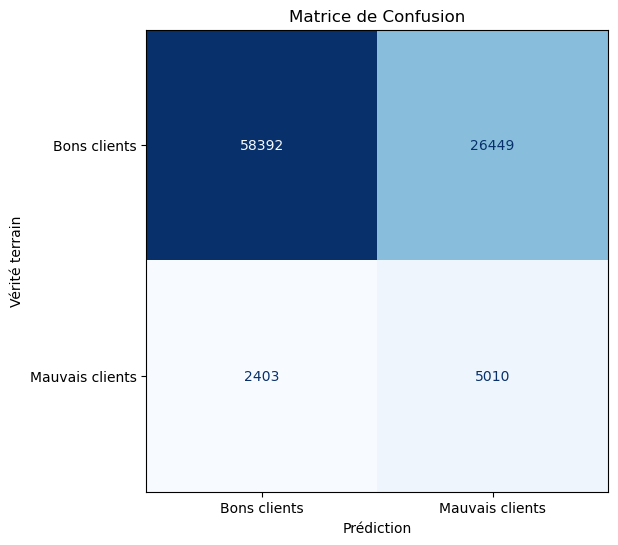

{'precision': 0.163,
 'recall': 0.6815,
 'f1': 0.263,
 'f1_beta': 0.6607,
 'roc_auc': 0.7528}

In [58]:
from catboost import CatBoostClassifier

arguments_modele={}

param_grid = {
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    "auto_class_weights":["Balanced"]
}

CatBoostClassifier_entraine = entrainementModeleAvecCV(CatBoostClassifier, arguments_modele, param_grid)
affichageResultatsModele(CatBoostClassifier_entraine)
#featureImportanceLocale(CatBoostClassifier_entraine, 0)

#### XGBoost

Meilleurs paramètres trouvés : {'gamma': 0, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 11.362566046404778}
Meilleur score F1-bêta : 0.30127116528989295


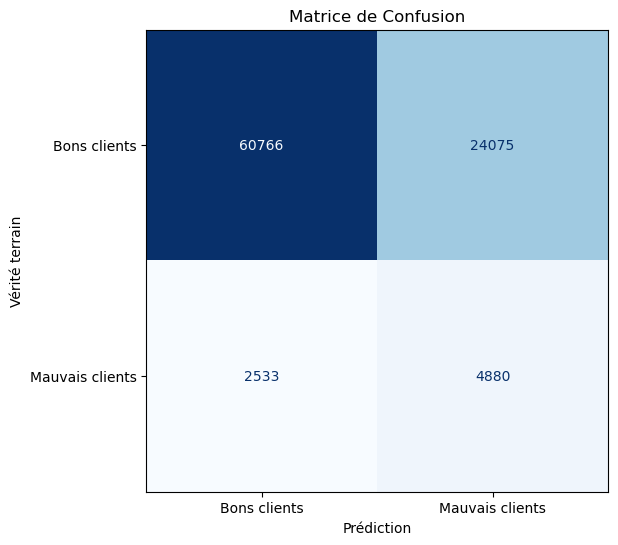

{'precision': 0.1685,
 'recall': 0.6583,
 'f1': 0.2684,
 'f1_beta': 0.4163,
 'roc_auc': 0.7541}

In [12]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

# XGBClassifier n'a pas de fonctionnalite intégrée pour équilibrer les classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
scale_pos_weight = class_weights_dict[1] / class_weights_dict[0]

arguments_modele={}

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight],
    'gamma':[0, 0.1, 0.2]
}

CatBoostClassifier_entraine = entrainementModeleAvecCV(XGBClassifier, arguments_modele, param_grid, 0.5)
affichageResultatsModele(CatBoostClassifier_entraine)
#featureImportanceLocale(CatBoostClassifier_entraine, 0)